# Chainer を使って MNIST database の分類をする

## Agenda
* Chainer とは
* MNIST とは
* 推奨開発環境構築方法（Mac）
* Chainer の MNIST サンプルプログラム実装の解説

## Chainer とは
PFN(PFI) が作った、ニューラルネットを誤差逆伝播法で学習するためのフレームワークです。  
PFI はよく見るあのスライドの会社。

\* ニューラルネットは、ロジスティック回帰と同様機械学習の手法の一つ。

PFI


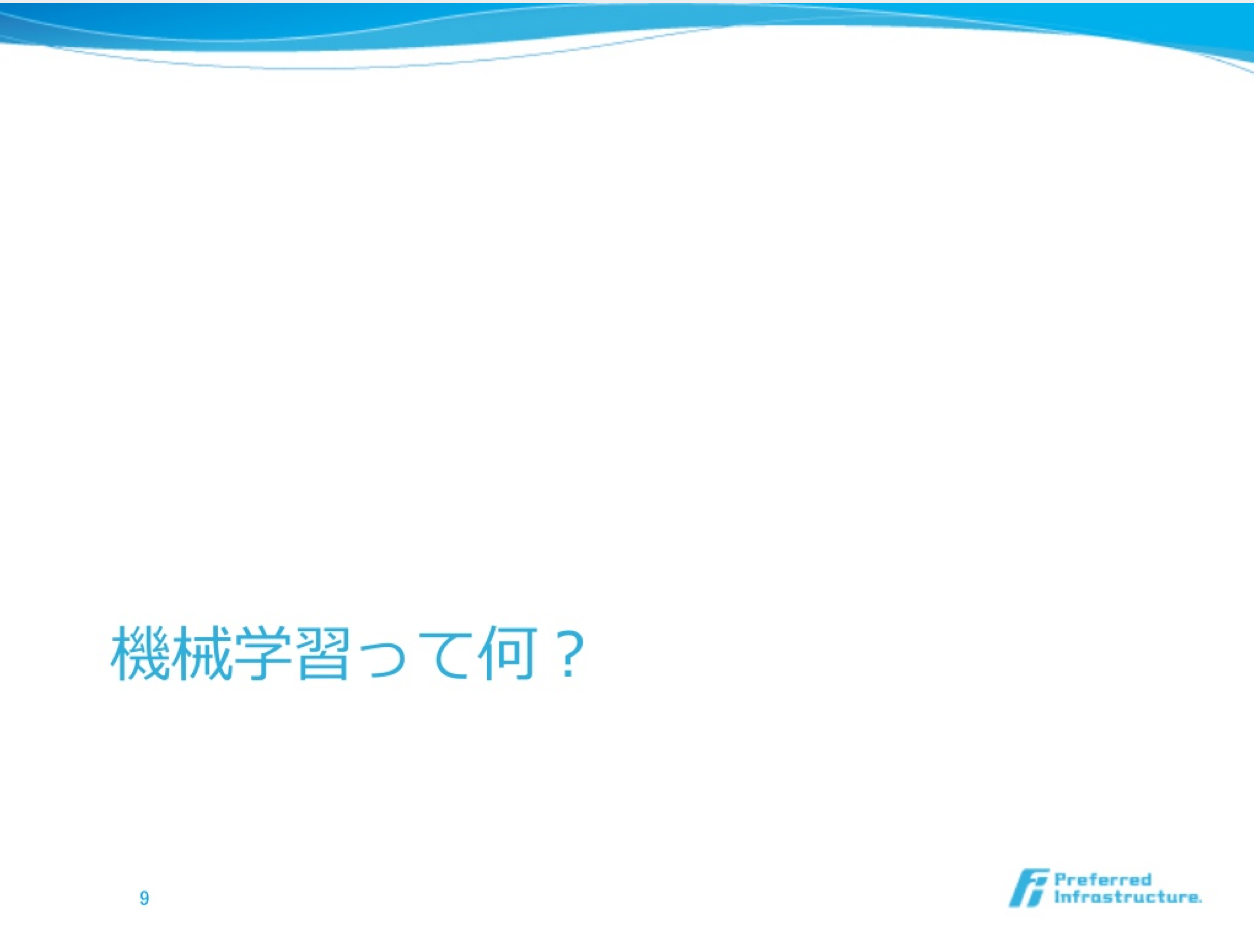

In [13]:
from IPython.display import Image

path = './images/pfi.png'
print ('PFI')
Image(path, width=300, height=300)

ロジスティック回帰の分類例


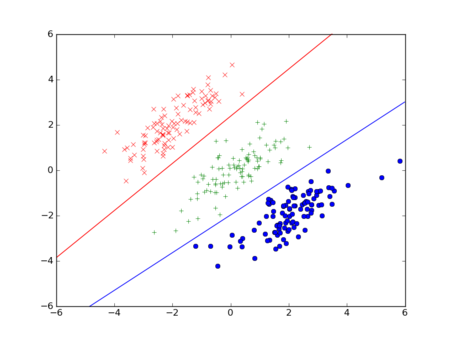

In [10]:
path = './images/logistic_regression.png'
print ('ロジスティック回帰の分類例')
Image(path, width=300, height=300)

ニューラルネットワークの分類例


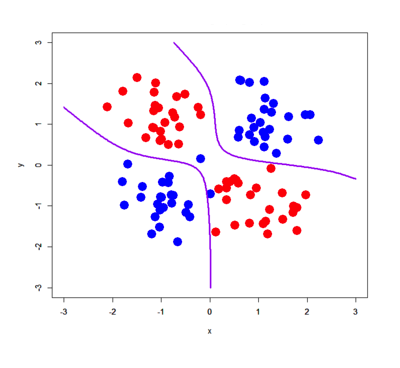

In [11]:
from IPython.display import Image

path = './images/neural_network.png'
print ('ニューラルネットワークの分類例')
Image(path, width=300, height=300)

## MNIST とは
MNIST database (Mixed National Institute of Standards and Technology database) のこと。
28x28pxの60000枚の学習サンプル、10000枚のテストサンプルからなる手書き数字画像データベースです。

\* database は整えられたデータの集まり、dataset は単なるデータの集まり

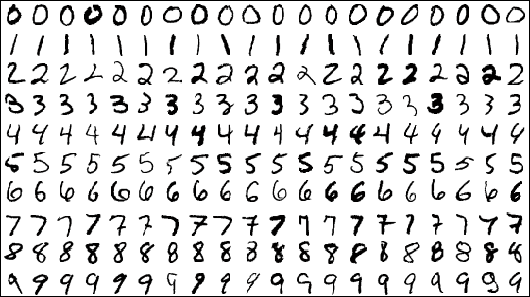

In [3]:
path = './images/mnist.png'
Image(path, width=300, height=300)

## 推奨開発環境構築方法（Mac）
詳細は他のサイトなど参照
```
http://qiita.com/oct_itmt/items/2d066801a7464a676994
http://qiita.com/y__sama/items/5b62d31cb7e6ed50f02c
```

* Homebrew インストール
```
/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
```

* Homebrew で pyenv インストール。pyenv の設定をする。
```
$ brew install pyenv
$ echo 'export PYENV_ROOT="${HOME}/.pyenv"' >> ~/.bash_profile
$ echo 'export PATH="${PYENV_ROOT}/bin:$PATH"' >> ~/.bash_profile
$ echo 'eval "$(pyenv init -)"' >> ~/.bash_profile
$ source ~/.bash_profile
```

* pyenv 経由で Anaconda をインストール
```
$ pyenv install anaconda-4.0.0
$ pyenv global anaconda-4.0.0
```
\* anaconda-4.0.0 が Python 2系、anaconda3-4.0.0 が Python 3系

* Anaconda で仮想環境構築
```
$ conda create -n <env-name> python=2.7 anaconda
```

## Chainer の MNIST サンプルプログラム実装の解説
だいたいこのサイトを読んだらわかってしまうと思います。
```
http://www.monthly-hack.com/entry/2016/07/14/173857
```

In [40]:
#!/usr/bin/env python

# Print関数の拡張機能import
from __future__ import print_function

try:
    import matplotlib
    # 画像をファイルとして出力するため
    matplotlib.use('Agg')
except ImportError:
    pass

# Chainer 関連のものimport
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

import numpy as np

In [23]:
# Network definition
class MLP(chainer.Chain):

    # ネットワークの定義
    # 層の深さ、n_unitsの数はデータの複雑さによって調整する
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__(
            # the size of the inputs to each layer will be inferred
            l1=L.Linear(None, n_units),  # n_in -> n_units
            l2=L.Linear(None, n_units),  # n_units -> n_units
            l3=L.Linear(None, n_out),  # n_units -> n_out
        )

    # 活性化関数。reluの他にはsigmoidなど。大体reluでいい。
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [24]:
class Parameters(object):

    def __init__(self, batchsize=100, epoch=20, gpu=-1, out='result', resume='', unit=1000):
        self.batchsize = batchsize # batchsize
        self.epoch = epoch # 繰り返し回数
        self.gpu = gpu # GPU を使うかどうか。
        self.out = out # Chainer の機能。結果の画像出力先のディレクトリ名
        self.resume = resume # Chainer の機能。次に学習を続きから続けたいときに使う
        self.unit = unit # それぞれの層のUnit数

In [25]:
parameters = Parameters(batchsize=100, epoch=5, unit=10)

print('GPU: {}'.format(parameters.gpu))
print('# unit: {}'.format(parameters.unit))
print('# Minibatch-size: {}'.format(parameters.batchsize))
print('# epoch: {}'.format(parameters.epoch))
print('')

GPU: -1
# unit: 10
# Minibatch-size: 100
# epoch: 5



In [26]:
# モデルのインスタンス化
# 10種類の手書き数字画像の分類なので、n_out=10
# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
model = L.Classifier(MLP(parameters.unit, n_out=10))

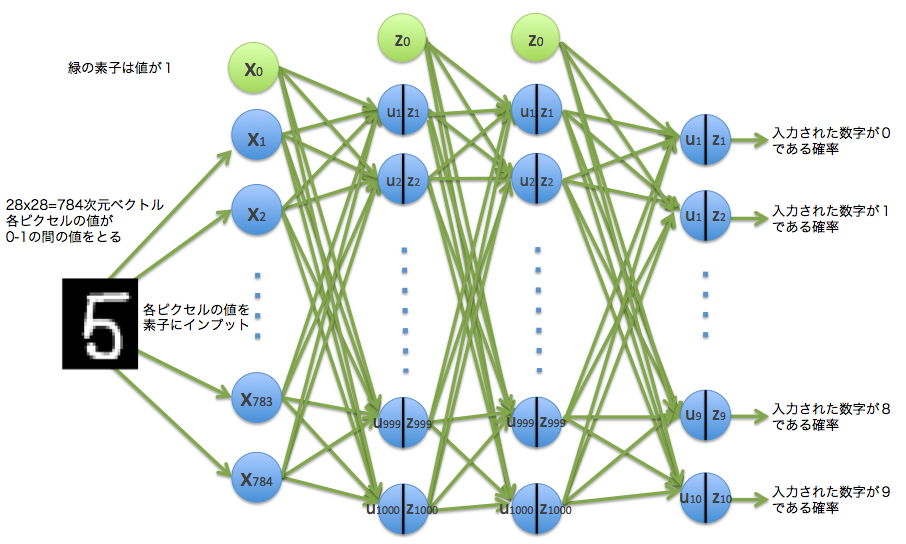

In [27]:
path = 'https://qiita-image-store.s3.amazonaws.com/0/50670/155b9533-4b47-0748-226c-1e3082930ed9.png'
Image(path, width=500, height=500)

In [29]:
if parameters.gpu >= 0:
    chainer.cuda.get_device(parameters.gpu).use()  # Make a specified GPU current
    model.to_gpu()  # Copy the model to the GPU

In [30]:
# 勾配降下法の最適化アルゴリズム
# Setup an optimizer
# http://docs.chainer.org/en/latest/reference/optimizers.html
#optimizer = chainer.optimizers.Adam()
optimizer = chainer.optimizers.MomentumSGD(lr=0.01, momentum=0.9)
optimizer.setup(model)

In [63]:
# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

fetch MNIST dataset


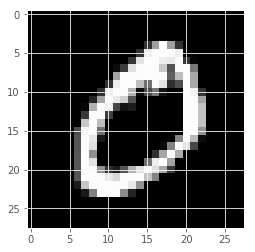

In [21]:
# 参考（MNISTの特徴量）
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
import chainer.functions as F
import sys

plt.style.use("ggplot")

batchsize = 100
n_epoch = 20
n_units = 1000 # 中間層
pixel_size = 28

# MNISTの画像データDL
print("fetch MNIST dataset")
mnist = fetch_mldata('MNIST original')
# mnist.data : 70,000件の28x28=784次元ベクトルデータ
mnist.data = mnist.data.astype(np.float32)
mnist.data /= 255  # 正規化

# mnist.target : 正解データ
mnist.target = mnist.target.astype(np.int32)

#print (mnist.data)

X = mnist.data
y = mnist.target

plt.imshow(X[0].reshape(28, 28), cmap='gray')
plt.show()


In [11]:
# minibatch に分けて処理するための設定
# train, test を batchsize でランダムに分割する
# 時系列データならshuffle=Falseとする
train_iter = chainer.iterators.SerialIterator(train, parameters.batchsize)
# テストなので、repeat=False
test_iter = chainer.iterators.SerialIterator(test, parameters.batchsize,
                                             repeat=False, shuffle=False)

NameError: name 'chainer' is not defined

In [40]:
# Set up a trainer
# http://docs.chainer.org/en/stable/reference/core/training.html#chainer.training.StandardUpdater
updater = training.StandardUpdater(iterator=train_iter, optimizer=optimizer, device=parameters.gpu)
# 本体。学習のときはTrainerのインスタンスをrunする
trainer = training.Trainer(updater, (parameters.epoch, 'epoch'), out=parameters.out)

In [41]:
# 学習をループさせている間に実行するものをextendで設定
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=parameters.gpu))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot at each epoch
trainer.extend(extensions.snapshot(), trigger=(parameters.epoch, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())



In [42]:
# スナップショットから再開
if parameters.resume:
    # Resume from a snapshot
    chainer.serializers.load_npz(parameters.resume, trainer)

In [43]:
# Run the training
trainer.run()

main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [#.................................................]  3.33%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 5 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [###...............................................]  6.67%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 5 epochs
    399.72 iters/sec. Estimated time to finish: 0:00:07.004960.
     total [#####.............................................] 10.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 5 epochs
    398.17 iters/sec. Estimated time to finish: 0:00:06.781050.
     total [######............................................] 13.33%
this epoch [#################################.................] 66.67%
       400 iter, 0 epoch / 5 epochs
     402.7 iter